In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install kmapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 392.6 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dzxovpdj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dzxovpdj
  Resolved https://github.com/openai/CLIP.git to commit b4ae44927b78d0093b556e3ce43cbdcff422017a
  Preparing metadata (setup.py) ... - done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369389 sha256=3878c8e4397d2e3420f0bc1988e839670f7f3223b325d7abb03ee6e53e3073ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-xw3j8ggk/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
from pkg_resources import packaging
import kmapper as km
from sklearn import cluster
from kmapper import jupyter

print("Torch version:", torch.__version__)

Torch version: 1.9.1


In [3]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 260MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fcce048d050>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]


In [7]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

1000 classes, 80 templates


In [8]:
imagenet_templates = imagenet_templates[:20]

In [9]:
!pip install git+https://github.com/modestyachts/ImageNetV2_pytorch
from imagenetv2_pytorch import ImageNetV2Dataset
images = ImageNetV2Dataset(transform=preprocess)
loader = torch.utils.data.DataLoader(images, batch_size=1, num_workers=1)

  Cloning https://github.com/modestyachts/ImageNetV2_pytorch to /tmp/pip-req-build-9ppyc3am
  Running command git clone --filter=blob:none --quiet https://github.com/modestyachts/ImageNetV2_pytorch /tmp/pip-req-build-9ppyc3am
  Resolved https://github.com/modestyachts/ImageNetV2_pytorch to commit 9017469c74e454c444bb48d19a4aa43211cc1f3a
  Preparing metadata (setup.py) ... - done
  Created wheel for imagenetv2-pytorch: filename=imagenetv2_pytorch-0.1-py3-none-any.whl size=2664 sha256=c702d827d3ae4db4f387feb028b2046d86aed01db2cd554fa02f944acdde74be
  Stored in directory: /tmp/pip-ephem-wheel-cache-h1i35uac/wheels/ab/ee/f4/73bce5c7f68d28ce632ef33ae87ce60aaca021eb2b3b31a6fa
Successfully built imagenetv2-pytorch
Dataset matched-frequency not found on disk, downloading....


100%|██████████| 1.26G/1.26G [01:10<00:00, 17.8MiB/s]


Extracting....


In [10]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
synonyms = []
antonyms = []
for syn in wordnet.synsets("bag"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())
antonyms

[]

In [12]:
def get_antonyms(syn_obj, im_texts):
    antonym_found = None
    for ant in syn_obj:
        for lemma in ant.lemmas():
            if lemma.antonyms():
                antonym = lemma.antonyms()[0].name().lower()
                antonym = antonym.replace('_',' ')
                antonym_found = antonym
                return antonym_found
    return antonym_found
    
def get_synonym(syn_obj, im_texts):    
    syn_found = None
    for synonynms_obj in syn_obj:
        for lemma in synonynms_obj.lemmas():
            synonym_word = lemma.name().lower()
            if synonym_word != im_texts:
                synonym_word = synonym_word.replace('_',' ')
                return synonym_word
    return im_texts

def create_synonyms(image_net_classes):
    syn_classes = []
    imagenet_classes = []
    ant_classes = []
    for image_texts in image_net_classes:
        im_texts = image_texts.lower()
        syn_obj = wordnet.synsets(im_texts)
        top_syn = get_synonym(syn_obj, image_texts)
        antonym = get_antonyms(syn_obj, image_texts)
        if top_syn:
            syn_classes.append(top_syn)
            ant_classes.append(antonym)
            imagenet_classes.append(image_texts)
            # print("original-  ", image_texts, "  synonynms ", top_syn)
    return syn_classes, imagenet_classes, ant_classes


In [13]:
syn_classes ,image_net_classes, ant_classes = create_synonyms(imagenet_classes)

Antonyms

In [14]:
for i in range(len(syn_classes)):
    if ant_classes[i]:
        print(i, ant_classes[i], " orig - ",image_net_classes[i])
        
# Lets choose 464, 488, 511 
# 464 - buckle - unbuckle
# 488 - chain - unchain
# 511 - convertible - unconvertible

114 work  orig -  slug
464 unbuckle  orig -  buckle
488 unchain  orig -  chain
502 unclog  orig -  clogs
511 inconvertible  orig -  convertible
519 uncrate  orig -  crate
536 undock  orig -  dock
600 unhook  orig -  hook
616 unravel  orig -  knot
626 heavy  orig -  lighter
643 unmask  orig -  mask
676 unmuzzle  orig -  muzzle
771 dangerous  orig -  safe
783 unscrew  orig -  screw
818 background  orig -  spotlight
857 dethrone  orig -  throne
896 source  orig -  sink
947 toadstool  orig -  mushroom


Synonmys

In [15]:
for i in range(len(syn_classes)):
  print(i, syn_classes[i], " orig - ",image_net_classes[i])

0 tinca tinca  orig -  tench
1 carassius auratus  orig -  goldfish
2 great white shark  orig -  great white shark
3 tiger shark  orig -  tiger shark
4 hammerhead shark  orig -  hammerhead shark
5 electric ray  orig -  electric ray
6 stingray  orig -  stingray
7 cock  orig -  rooster
8 biddy  orig -  hen
9 struthio camelus  orig -  ostrich
10 fringilla montifringilla  orig -  brambling
11 new world goldfinch  orig -  goldfinch
12 house finch  orig -  house finch
13 snowbird  orig -  junco
14 indigo bunting  orig -  indigo bunting
15 American robin  orig -  American robin
16 bulbul  orig -  bulbul
17 john jay  orig -  jay
18 scavenger  orig -  magpie
19 chickadee  orig -  chickadee
20 American dipper  orig -  American dipper
21 kite (bird of prey)  orig -  kite (bird of prey)
22 bald eagle  orig -  bald eagle
23 marauder  orig -  vulture
24 great grey owl  orig -  great grey owl
25 fire salamander  orig -  fire salamander
26 smooth newt  orig -  smooth newt
27 triton  orig -  newt
28 spo

In [16]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            #class_embedding = class_embeddings.mean(dim=0)
            #class_embedding /= class_embedding.norm()
            class_embedding = class_embeddings
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=2).cuda()
    return zeroshot_weights

In [17]:
zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates)
zeroshot_weights_synonyms = zeroshot_classifier(syn_classes, imagenet_templates)
zeroshot_weights_antonyms = zeroshot_classifier(ant_classes, imagenet_templates)

zeroshot_weights_emb = zeroshot_weights.permute(0,2,1).reshape(20000, -1)
zeroshot_weights_emb_syn = zeroshot_weights_synonyms.permute(0,2,1).reshape(20000, -1)
zeroshot_weights_emb_ant = zeroshot_weights_antonyms.permute(0,2,1).reshape(20000, -1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
def get_img_template_map(img, target, outpath, zero_shot_weights_emb, emb_classes):
    pred_logits = predict(img, zero_shot_weights_emb).squeeze(1)
    pred_class = emb_classes[int(pred_logits.reshape(20, 1000).mean(dim=0).argmax().detach().cpu().numpy())]
   # pred_class_neg = imagenet_classes[int(pred_logits[80:,...].mean(dim=0).argmax().detach().cpu().numpy())]
    pred_most_prob, pred_second = torch.topk(pred_logits, 2, dim=1)
   
    print(f'gt class:{emb_classes[int(target.detach().cpu().numpy())]}, pred_class:{pred_class}')
    fig = plt.figure()
    plt.imshow(img[0,...].detach().cpu().numpy().transpose(1,2,0))
    #pred_conf = pred_logits[:,target].detach().cpu().numpy()
    pred_conf = (pred_most_prob - pred_second).detach().cpu().numpy()
    pred_logits_np = pred_logits.detach().cpu().numpy()
    mapper = km.KeplerMapper(verbose=2)
    G = mapper.map(pred_logits_np.T,
               zero_shot_weights_emb.cpu().detach().numpy(),
               cover = km.Cover(n_cubes=10,
                               perc_overlap=0.5),
               clusterer=cluster.AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
               )
    _ = mapper.visualize(G,
                     lens=pred_logits_np.T,
                     lens_names=["Margin"],
                     #custom_tooltips=imagenet_templates,
                     #X_names=imagenet_templates,
                     color_values=col_vals,
                     color_function_name=['Absolute error'],
                     #title="Confidence Graph for a MLP trained on MNIST",
                     path_html=outpath)
    jupyter.display(outpath)
    return G

In [19]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


In [20]:
def predict(img, txt_embs):
    img = img.cuda()
    image_features = model.encode_image(img)
    print(image_features.shape, txt_embs.shape)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    logits = []
    logits = image_features @ txt_embs.T
    #logits = torch.stack(logits, dim=0)
    return logits

# Lets choose 464, 488, 511 for antonyms

Lets choose 464, 488, 511 
464 - buckle - unbuckle
488 - chain - unchain
511 - convertible - unconvertible

In [21]:
im_list = []
tar_list = []
for i, (images, target) in enumerate(tqdm(loader)):
    if target[0].item()-511 == 0:
        im_list.append(images[0,...])
        tar_list.append(target[0, ...])
        print(i)

  0%|          | 0/10000 [00:00<?, ?it/s]

2230
2231
2232
2233
2234
2235
2236
2237
2238
2239


In [22]:
im_list[1].shape

torch.Size([3, 224, 224])

torch.Size([1, 3, 224, 224])
tensor(511)


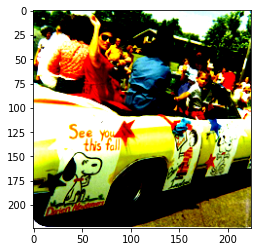

In [23]:
k = im_list[3]
p = k.unsqueeze(0)
print(p.shape)
t = tar_list[3]
print(tar_list[5])
from matplotlib import pyplot as plt
plt.imshow(k.detach().cpu().numpy().transpose(1,2,0))

In [24]:
t.item()

511

# Normal imagenet label

torch.Size([1, 512]) torch.Size([20000, 512])
gt class:convertible, pred_class:race car
KeplerMapper(verbose=2)
Mapping on data shaped (20000, 512) using lens shaped (20000, 1)

Minimal points in hypercube before clustering: 2
Creating 10 hypercubes.
   > Found 2 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 2 clusters in hypercube 3.
   > Found 2 clusters in hypercube 4.
   > Found 2 clusters in hypercube 5.
   > Found 2 clusters in hypercube 6.
   > Found 2 clusters in hypercube 7.
   > Found 2 clusters in hypercube 8.
   > Found 2 clusters in hypercube 9.

Created 32 edges and 20 nodes in 0:01:05.400063.
Wrote visualization to: convertible_0.html


/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


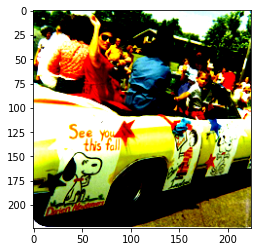

In [25]:
col_vals= np.arange(0,20000)+1
col_vals = col_vals % 20
graphs = []
for i in range(1):
    tmp_g = get_img_template_map(k.unsqueeze(0), target=t, outpath=f'{imagenet_classes[t.item()]}_{i}.html',zero_shot_weights_emb=zeroshot_weights_emb, emb_classes=imagenet_classes)


# synonym imagenet label

torch.Size([1, 512]) torch.Size([20000, 512])
gt class:convertible security, pred_class:race car
KeplerMapper(verbose=2)
Mapping on data shaped (20000, 512) using lens shaped (20000, 1)

Minimal points in hypercube before clustering: 2
Creating 10 hypercubes.
   > Found 2 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 2 clusters in hypercube 3.
   > Found 2 clusters in hypercube 4.
   > Found 2 clusters in hypercube 5.
   > Found 2 clusters in hypercube 6.
   > Found 2 clusters in hypercube 7.
   > Found 2 clusters in hypercube 8.
   > Found 2 clusters in hypercube 9.

Created 34 edges and 20 nodes in 0:01:05.115335.
Wrote visualization to: convertible_0_syn.html


/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


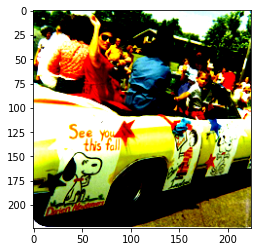

In [26]:
for i in range(1):
    tmp_g = get_img_template_map(k.unsqueeze(0), target=t, outpath=f'{imagenet_classes[t.item()]}_{i}_syn.html',zero_shot_weights_emb=zeroshot_weights_emb_syn,emb_classes=syn_classes)


# antonym experiment

torch.Size([1, 512]) torch.Size([20000, 512])
gt class:inconvertible, pred_class:inconvertible
KeplerMapper(verbose=2)
Mapping on data shaped (20000, 512) using lens shaped (20000, 1)

Minimal points in hypercube before clustering: 2
Creating 10 hypercubes.
   > Found 2 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 2 clusters in hypercube 3.
   > Found 2 clusters in hypercube 4.
   > Found 2 clusters in hypercube 5.
   > Found 2 clusters in hypercube 6.
   > Found 2 clusters in hypercube 7.
   > Found 2 clusters in hypercube 8.
   > Found 2 clusters in hypercube 9.

Created 17 edges and 20 nodes in 0:01:20.315156.
Wrote visualization to: convertible_0_ant.html


/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


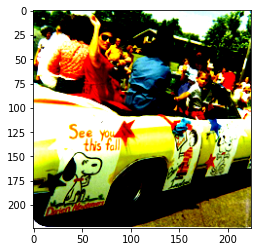

In [27]:
for i in range(1):
    tmp_g = get_img_template_map(k.unsqueeze(0), target=t, outpath=f'{imagenet_classes[t.item()]}_{i}_ant.html',zero_shot_weights_emb=zeroshot_weights_emb_ant, emb_classes=ant_classes)
